In [89]:
import os
import sys
from pathlib import Path

project_root = Path().resolve().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

try:
    from dotenv import load_dotenv
    env_path = project_root / ".env"
    if env_path.exists():
        load_dotenv(env_path)
        print(f"Loaded .env from {env_path}")
    else:
        load_dotenv()
except ImportError:
    print("python-dotenv not available, skipping .env loading")

print(f"Project root: {project_root}")
print(f"Python path includes: {project_root in [Path(p) for p in sys.path]}")


Project root: /Users/aadisarma/GT25/CS8803/LLM-Auto-Commentary
Python path includes: True


In [90]:
import importlib

import src.data_loading.cricket_dataset as cd
importlib.reload(cd)

import src.data_loading.windowed_cricket_dataset as wcd
importlib.reload(wcd)

import src.data_processing.preprocess as prep
importlib.reload(prep)

import src.training.train_seq_classifier as tsc
importlib.reload(tsc)
from src.training.train_seq_classifier import train_seq_classifier

import src.eval.eval_protocols as evp
importlib.reload(evp)
import src.eval.metrics as evm
importlib.reload(evm)

print("Modules (re)loaded.")

Modules (re)loaded.


In [91]:
data_root = os.getenv("VISIG_ROOT")

if not data_root:
    data_root = str(project_root / "visig_body_signal_data" / "data" / "cricket")
    print(f"VISIG_ROOT not set, using default: {data_root}")
else:
    print(f"Using VISIG_ROOT: {data_root}")

if not Path(data_root).exists():
    raise FileNotFoundError(f"Data directory not found: {data_root}")

print(f"Data directory exists: {Path(data_root).exists()}")


VISIG_ROOT not set, using default: /Users/aadisarma/GT25/CS8803/LLM-Auto-Commentary/visig_body_signal_data/data/cricket
Data directory exists: True


Without LOPO

In [92]:
HYPERPARAMS = {
    "max_len": 400,
    "batch_size": 32,           
    "lr": 1e-3,
    "num_epochs": 50,
    "patience": 8,
    "model_dir": "../src/models/checkpoints",
    "model_type": "lstm",
    "loss_type": "ce",
    "use_windows": True,
    "window_size": 32,
    "stride": 8,
    "standardize": True,
    "imu_zero_offset": True,
    "lowpass_k": 5,
    "uwb_correct": True,
    "stratified_split": True
}

print("Hyperparameters:")
for key, value in HYPERPARAMS.items():
    print(f"  {key}: {value}")


Hyperparameters:
  max_len: 400
  batch_size: 32
  lr: 0.001
  num_epochs: 50
  patience: 8
  model_dir: ../src/models/checkpoints
  model_type: lstm
  loss_type: ce
  use_windows: True
  window_size: 32
  stride: 8
  standardize: True
  imu_zero_offset: True
  lowpass_k: 5
  uwb_correct: True
  stratified_split: True


In [93]:
results, history = train_seq_classifier(
    data_root=data_root,
    return_history=True,
    **HYPERPARAMS
)

print(f"\nTraining completed!")
print(f"Best validation accuracy: {results['best_val_acc']:.3f}")
print(f"Test accuracy: {results['test_acc']:.3f}")
print(f"Model saved to: {results['checkpoint_path']}")


Using device: cpu
Input dim: 195, num_classes: 10
Dataset sizes -> train: 60, val: 10, test: 10
Saved windowed standardizer to ../src/models/checkpoints/scaler_windowed.pt
Using windowed datasets -> train_windows: 2068, val_windows: 360, test_windows: 348
[dbg] batch0 valid_frac=1.000, len(min/mean/max)=32/32.0/32
Epoch 001: train_loss=1.1483, train_acc=0.730, val_acc=0.919, best_val_acc=0.919, no_improve=0
[dbg] batch0 valid_frac=1.000, len(min/mean/max)=32/32.0/32
Epoch 002: train_loss=0.1067, train_acc=0.976, val_acc=0.956, best_val_acc=0.956, no_improve=0
[dbg] batch0 valid_frac=1.000, len(min/mean/max)=32/32.0/32
Epoch 003: train_loss=0.0447, train_acc=0.991, val_acc=0.969, best_val_acc=0.969, no_improve=0
[dbg] batch0 valid_frac=1.000, len(min/mean/max)=32/32.0/32
Epoch 004: train_loss=0.0563, train_acc=0.987, val_acc=0.936, best_val_acc=0.969, no_improve=1
[dbg] batch0 valid_frac=1.000, len(min/mean/max)=32/32.0/32
Epoch 005: train_loss=0.0564, train_acc=0.984, val_acc=0.981, be

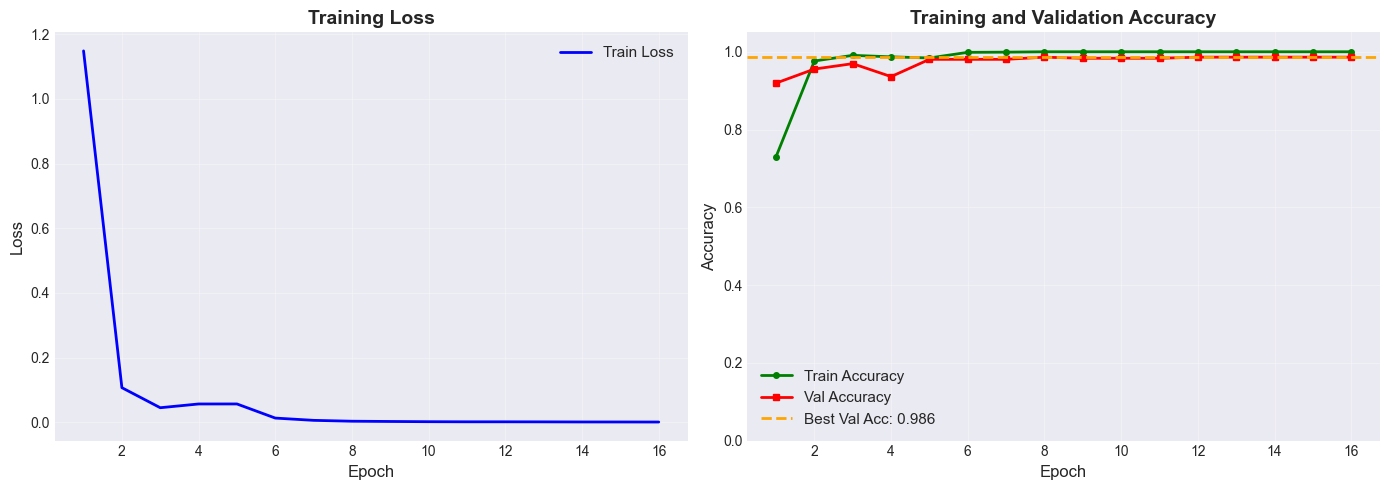


Final metrics:
  Train Loss: 0.0005
  Train Accuracy: 1.000
  Val Accuracy: 0.986
  Best Val Accuracy: 0.986
  Test Accuracy: 0.943


In [94]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

try:
    plt.style.use('seaborn-v0_8-darkgrid')
except OSError:
    try:
        plt.style.use('seaborn-darkgrid')
    except OSError:
        plt.style.use('default')
sns.set_palette("husl")


if history:
    epochs = [h['epoch'] for h in history]
    train_losses = [h['train_loss'] for h in history]
    train_accs = [h['train_acc'] for h in history]
    val_accs = [h['val_acc'] for h in history]
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].plot(epochs, train_losses, 'b-', label='Train Loss', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Training Loss', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(epochs, train_accs, 'g-', label='Train Accuracy', linewidth=2, marker='o', markersize=4)
    axes[1].plot(epochs, val_accs, 'r-', label='Val Accuracy', linewidth=2, marker='s', markersize=4)
    axes[1].axhline(y=results['best_val_acc'], color='orange', linestyle='--', 
                    label=f'Best Val Acc: {results["best_val_acc"]:.3f}', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)
    axes[1].set_ylim([0, 1.05])
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nFinal metrics:")
    print(f"  Train Loss: {train_losses[-1]:.4f}")
    print(f"  Train Accuracy: {train_accs[-1]:.3f}")
    print(f"  Val Accuracy: {val_accs[-1]:.3f}")
    print(f"  Best Val Accuracy: {results['best_val_acc']:.3f}")
    print(f"  Test Accuracy: {results['test_acc']:.3f}")
else:
    print("No training history available.")


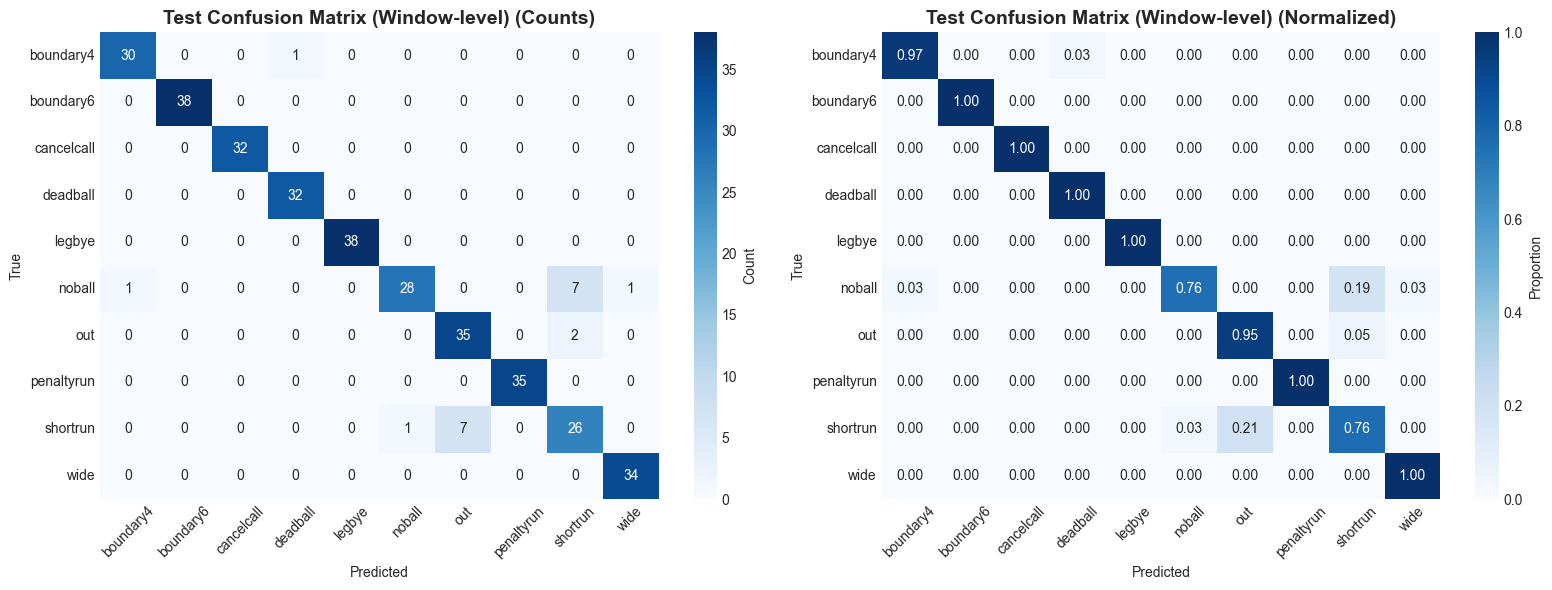


Per-class Accuracy (Window-level):
  boundary4      : 0.968 (30/31)
  boundary6      : 1.000 (38/38)
  cancelcall     : 1.000 (32/32)
  deadball       : 1.000 (32/32)
  legbye         : 1.000 (38/38)
  noball         : 0.757 (28/37)
  out            : 0.946 (35/37)
  penaltyrun     : 1.000 (35/35)
  shortrun       : 0.765 (26/34)
  wide           : 1.000 (34/34)

Window-level Accuracy: 0.943


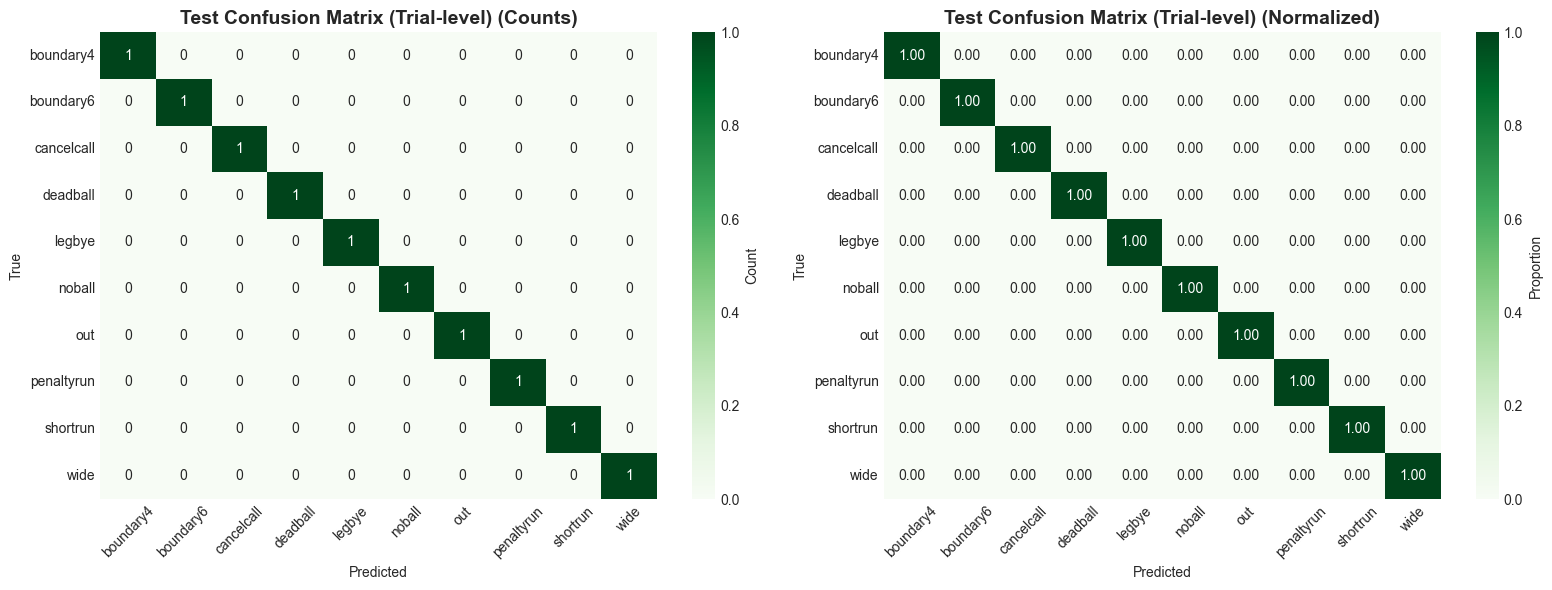


Per-class Accuracy (Trial-level):
  boundary4      : 1.000 (1/1)
  boundary6      : 1.000 (1/1)
  cancelcall     : 1.000 (1/1)
  deadball       : 1.000 (1/1)
  legbye         : 1.000 (1/1)
  noball         : 1.000 (1/1)
  out            : 1.000 (1/1)
  penaltyrun     : 1.000 (1/1)
  shortrun       : 1.000 (1/1)
  wide           : 1.000 (1/1)

Trial-level Accuracy: 1.000


In [95]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_cm(cm, labels, title, cmap):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # counts
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap,
                xticklabels=labels, yticklabels=labels,
                ax=axes[0], cbar_kws={'label': 'Count'})
    axes[0].set_title(f'{title} (Counts)', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('True')
    axes[0].tick_params(axis='x', rotation=45); axes[0].tick_params(axis='y', rotation=0)

    # normalized
    row_sums = cm.sum(axis=1, keepdims=True)
    cm_norm = np.divide(cm, row_sums, out=np.zeros_like(cm, dtype=float), where=row_sums!=0)
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap=cmap,
                xticklabels=labels, yticklabels=labels,
                ax=axes[1], cbar_kws={'label': 'Proportion'})
    axes[1].set_title(f'{title} (Normalized)', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Predicted'); axes[1].set_ylabel('True')
    axes[1].tick_params(axis='x', rotation=45); axes[1].tick_params(axis='y', rotation=0)

    plt.tight_layout()
    plt.show()

def print_per_class(cm, labels, header):
    print(header)
    for i, name in enumerate(labels):
        total = cm[i, :].sum()
        correct = cm[i, i]
        acc = correct / max(1, total)
        print(f"  {name:15s}: {acc:.3f} ({int(correct)}/{int(total)})")

labels = results["label_names"]

cm_window = results["confusion_matrix"]
plot_cm(cm_window, labels, title="Test Confusion Matrix (Window-level)", cmap="Blues")
print_per_class(cm_window, labels, header="\nPer-class Accuracy (Window-level):")
if "window_level_accuracy" in results:
    print(f"\nWindow-level Accuracy: {results['window_level_accuracy']:.3f}")

if "trial_level_confusion_matrix" in results:
    cm_trial = results["trial_level_confusion_matrix"]
    plot_cm(cm_trial, labels, title="Test Confusion Matrix (Trial-level)", cmap="Greens")
    print_per_class(cm_trial, labels, header="\nPer-class Accuracy (Trial-level):")
    if "trial_level_accuracy" in results:
        print(f"\nTrial-level Accuracy: {results['trial_level_accuracy']:.3f}")
else:
    print("\n[info] Trial-level matrix not available. Ensure use_windows=True (and prefer stratified_split=True) during training.")

With LOPO

In [98]:
import importlib
import numpy as np
import torch
from torch.utils.data import DataLoader

import src.eval.eval_protocols as evp
import src.data_loading.cricket_dataset as cd
import src.data_loading.windowed_cricket_dataset as wcd
import src.data_processing.preprocess as prep
import src.models.seq_lstm as m_lstm
import src.models.seq_cnn as m_cnn
import src.training.train_seq_classifier as tsc

importlib.reload(evp); importlib.reload(cd); importlib.reload(wcd)
importlib.reload(prep); importlib.reload(m_lstm); importlib.reload(m_cnn); importlib.reload(tsc)

def build_windowed_loaders_from_samples(train_s, val_s, test_s,
                                        batch_size=32, window_size=32, stride=8,
                                        standardize=True, imu_zero_offset=True, lowpass_k=5, uwb_correct=True):
    label_to_idx = cd.build_label_mapping(train_s + val_s + test_s)

    tlist = []
    if imu_zero_offset: tlist.append(prep.IMUZeroOffset())
    if lowpass_k and lowpass_k > 1: tlist.append(prep.LowPassSmooth(kernel_size=lowpass_k))
    if uwb_correct: tlist.append(prep.UWBCorrectStaticClamp())
    pre_tfm = prep.Compose(tlist) if tlist else None

    w_train_tmp = wcd.WindowedCricketDataset(train_s, label_to_idx, window_size, stride, 0.0, True, transform=pre_tfm)
    std_tfm = None
    if standardize:
        mean, std = prep.StandardizeFeatures.compute_mean_std_over_dataset(w_train_tmp)
        std_tfm = prep.StandardizeFeatures(mean=mean, std=std)

    parts = []
    if pre_tfm is not None and len(pre_tfm) > 0: parts.extend(pre_tfm.transforms)
    if std_tfm is not None: parts.append(std_tfm)
    full_tfm = prep.Compose(parts) if parts else None

    w_train = wcd.WindowedCricketDataset(train_s, label_to_idx, window_size, stride, 0.0, True, transform=full_tfm)
    w_val   = wcd.WindowedCricketDataset(val_s,   label_to_idx, window_size, stride, 0.0, True, transform=full_tfm)
    w_test  = wcd.WindowedCricketDataset(test_s,  label_to_idx, window_size, stride, 0.0, True, transform=full_tfm)

    return (
        DataLoader(w_train, batch_size=batch_size, shuffle=True),
        DataLoader(w_val,   batch_size=batch_size, shuffle=False),
        DataLoader(w_test,  batch_size=batch_size, shuffle=False),
        w_train.feature_dim, w_train.num_classes, sorted(label_to_idx, key=lambda k: label_to_idx[k])
    )

def build_model(model_type, input_dim, num_classes):
    if model_type == "cnn":
        return m_cnn.SimpleCricketCNN(input_dim, num_classes, num_channels=128, num_layers=2, kernel_size=5, dropout=0.3)
    return m_lstm.SimpleCricketLSTM(input_dim, num_classes, hidden_size=128, num_layers=1, dropout=0.2, head_hidden=128)

def run_fold(train_s_all, test_s, pid, model_type="lstm", epochs=40, patience=8, lr=1e-3):
    # stratified split train->train/val
    tr_s, va_s, _ = cd.stratified_trial_split(train_s_all, train_ratio=0.85, val_ratio=0.15, seed=pid)
    train_loader, val_loader, test_loader, in_dim, n_cls, _ = build_windowed_loaders_from_samples(
        tr_s, va_s, test_s, batch_size=32, window_size=32, stride=8,
        standardize=True, imu_zero_offset=True, lowpass_k=5, uwb_correct=True
    )
    device = tsc.get_device()
    model = build_model(model_type, in_dim, n_cls).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    crit = torch.nn.CrossEntropyLoss()

    best_val, best = 0.0, None
    no_imp = 0
    for ep in range(1, epochs+1):
        tsc.train_one_epoch(model, train_loader, crit, opt, device)
        va = tsc.evaluate_accuracy(model, val_loader, device)
        if va > best_val + 1e-4:
            best_val, best, no_imp = va, model.state_dict(), 0
        else:
            no_imp += 1
        if no_imp >= patience:
            break
    if best: model.load_state_dict(best)
    test_acc = tsc.evaluate_accuracy(model, test_loader, device)
    lab_map = {i: n for i, n in enumerate(test_loader.dataset.label_to_idx.keys())}
    wt = tsc.evaluate_window_and_trial_level(model, test_loader, device, label_names=lab_map, use_trial_level=True)
    return {"pid": pid, "test_acc": float(test_acc), "window_acc": wt.get("window_accuracy"), "trial_acc": wt.get("trial_accuracy")}

folds = evp.make_lopo_splits(data_root)
fold_results = []
for train_all, test_only, pid in folds:
    res = run_fold(train_all, test_only, pid, model_type="lstm", epochs=40, patience=8, lr=1e-3)
    fold_results.append(res)
    print(res)

def avg_std(key):
    vals = [r[key] for r in fold_results if r.get(key) is not None]
    return float(np.mean(vals)), float(np.std(vals))

print("LOPO summary:")
print("  test_acc mean±std     :", avg_std("test_acc"))
print("  window_acc mean±std   :", avg_std("window_acc"))
print("  trial_acc mean±std    :", avg_std("trial_acc"))

[dbg] batch0 valid_frac=1.000, len(min/mean/max)=32/32.0/32
[dbg] batch0 valid_frac=1.000, len(min/mean/max)=32/32.0/32
[dbg] batch0 valid_frac=1.000, len(min/mean/max)=32/32.0/32
[dbg] batch0 valid_frac=1.000, len(min/mean/max)=32/32.0/32
[dbg] batch0 valid_frac=1.000, len(min/mean/max)=32/32.0/32
[dbg] batch0 valid_frac=1.000, len(min/mean/max)=32/32.0/32
[dbg] batch0 valid_frac=1.000, len(min/mean/max)=32/32.0/32
[dbg] batch0 valid_frac=1.000, len(min/mean/max)=32/32.0/32
[dbg] batch0 valid_frac=1.000, len(min/mean/max)=32/32.0/32
[dbg] batch0 valid_frac=1.000, len(min/mean/max)=32/32.0/32
[dbg] batch0 valid_frac=1.000, len(min/mean/max)=32/32.0/32
[dbg] batch0 valid_frac=1.000, len(min/mean/max)=32/32.0/32
{'pid': 1, 'test_acc': 0.9411764705882353, 'window_acc': 0.9411764705882353, 'trial_acc': 1.0}
[dbg] batch0 valid_frac=1.000, len(min/mean/max)=32/32.0/32
[dbg] batch0 valid_frac=1.000, len(min/mean/max)=32/32.0/32
[dbg] batch0 valid_frac=1.000, len(min/mean/max)=32/32.0/32
[dbg]

,pid,test_acc,window_acc,trial_acc
0,1,0.941176,0.941176,1.0
1,2,0.928125,0.928125,1.0
2,3,1.000000,1.000000,1.0
3,4,0.962209,0.962209,1.0
4,5,0.991354,0.991354,1.0
5,6,0.995012,0.995012,1.0
6,7,0.968023,0.968023,1.0
7,8,0.967456,0.967456,1.0



LOPO summary (mean ± std):
  Test Acc     : 0.969 ± 0.024  (n=8)
  Window Acc   : 0.969 ± 0.024  (n=8)
  Trial Acc    : 1.000 ± 0.000  (n=8)


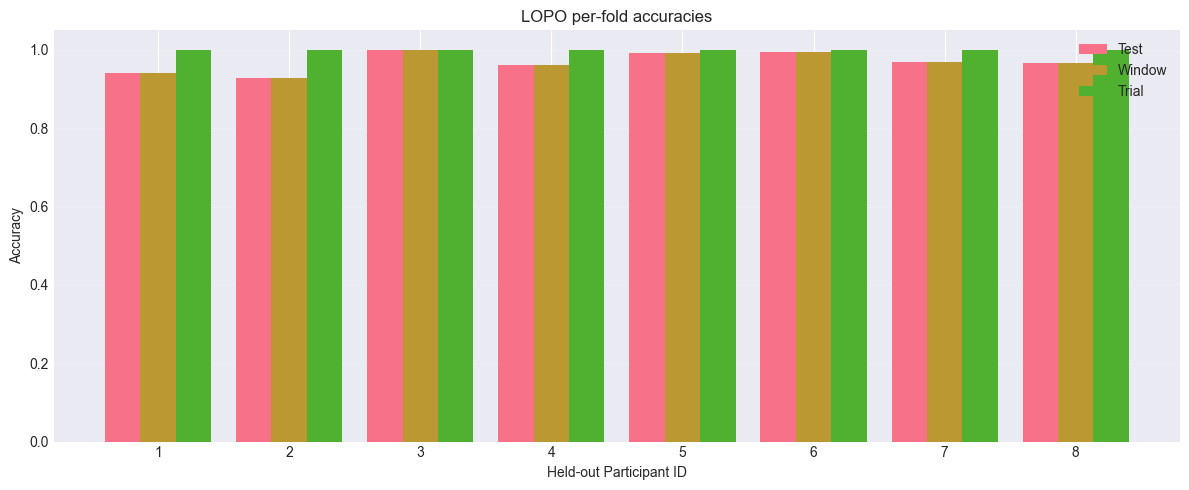

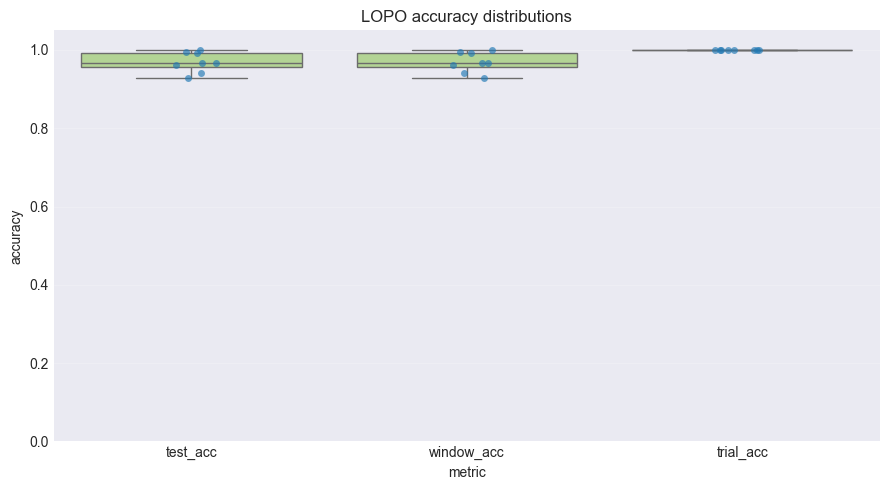


Summary JSON:
 {'test_acc_mean': 0.9691695732145331, 'test_acc_std': 0.024061140366951804, 'n_test': 8, 'window_acc_mean': 0.9691695732145331, 'window_acc_std': 0.024061140366951804, 'n_window': 8, 'trial_acc_mean': 1.0, 'trial_acc_std': 0.0, 'n_trial': 8}


In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# fold_results must exist: list of dicts with keys: pid, test_acc, window_acc, trial_acc
df = pd.DataFrame(fold_results).sort_values(by="pid").reset_index(drop=True)
display(df)

def mean_std(col):
    vals = df[col].dropna().values
    return float(np.mean(vals)), float(np.std(vals)), len(vals)

m_test, s_test, n_test = mean_std("test_acc")
m_win,  s_win,  n_win  = mean_std("window_acc")
m_tri,  s_tri,  n_tri  = mean_std("trial_acc")

print("\nLOPO summary (mean ± std):")
print(f"  Test Acc     : {m_test:.3f} ± {s_test:.3f}  (n={n_test})")
print(f"  Window Acc   : {m_win :.3f} ± {s_win :.3f}  (n={n_win })")
print(f"  Trial Acc    : {m_tri :.3f} ± {s_tri :.3f}  (n={n_tri })")

# Per-fold bar plot
plt.figure(figsize=(12,5))
x = np.arange(len(df))
w = 0.27
plt.bar(x - w, df["test_acc"],   width=w, label="Test")
plt.bar(x,       df["window_acc"], width=w, label="Window")
plt.bar(x + w,   df["trial_acc"],  width=w, label="Trial")
plt.xticks(x, df["pid"].astype(str))
plt.ylabel("Accuracy")
plt.xlabel("Held-out Participant ID")
plt.title("LOPO per-fold accuracies")
plt.ylim(0, 1.05)
plt.legend()
plt.grid(axis="y", alpha=0.2)
plt.tight_layout()
plt.show()

# Distribution view (box/strip)
plt.figure(figsize=(9,5))
plot_df = df.melt(id_vars=["pid"], value_vars=["test_acc","window_acc","trial_acc"],
                  var_name="metric", value_name="accuracy")
sns.boxplot(data=plot_df, x="metric", y="accuracy", color="#B2DF8A")
sns.stripplot(data=plot_df, x="metric", y="accuracy", color="#1F78B4", alpha=0.65)
plt.ylim(0, 1.05)
plt.title("LOPO accuracy distributions")
plt.grid(axis="y", alpha=0.2)
plt.tight_layout()
plt.show()

# Optional: save summary
summary = {
    "test_acc_mean": m_test, "test_acc_std": s_test, "n_test": n_test,
    "window_acc_mean": m_win, "window_acc_std": s_win, "n_window": n_win,
    "trial_acc_mean": m_tri, "trial_acc_std": s_tri, "n_trial": n_tri,
}
print("\nSummary JSON:\n", summary)